# Model comparison 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import warnings
import time
import os

# For better plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
warnings.filterwarnings('ignore')

# Import the permutation weighting implementation
import sys
sys.path.append('.')  # Add the current directory to path
try:
    from permutation_weighting.estimator import PW
    print("Successfully imported PW from the package")
except ImportError:
    print("Failed to import PW from the package - will implement a simplified version")

# Kang-Schafer DGP for binary treatment
def generate_kang_schafer_binary(n=1000, seed=42, misspecified=False):
    """
    Generate data according to the Kang-Schafer setup with binary treatment
    
    Parameters:
    -----------
    n: int
        Number of observations
    seed: int
        Random seed
    misspecified: bool
        Whether to return the misspecified transformations of covariates
        
    Returns:
    --------
    df: pd.DataFrame
        Data frame with columns: X1-X4 (covariates), A (treatment), Y (outcome), 
        Y1 (potential outcome under treatment), Y0 (potential outcome under control),
        and X1_mis to X4_mis (misspecified covariates, if requested)
    """
    np.random.seed(seed)
    
    # Generate covariates
    X = np.random.normal(0, 1, size=(n, 4))
    
    # Treatment assignment
    ps_linear = X[:, 0] - 0.5 * X[:, 1] + 0.25 * X[:, 2] + 0.1 * X[:, 3]
    ps = expit(ps_linear)
    A = np.random.binomial(1, ps, size=n)
    
    # Generate potential outcomes
    Y1 = 210 + 1 + 27.4*X[:, 0] + 13.7*X[:, 1] + 13.7*X[:, 2] + 13.7*X[:, 3] + np.random.normal(0, 1, size=n)
    Y0 = 210 + 0 + 27.4*X[:, 0] + 13.7*X[:, 1] + 13.7*X[:, 2] + 13.7*X[:, 3] + np.random.normal(0, 1, size=n)
    
    # Observed outcome
    Y = A * Y1 + (1 - A) * Y0
    
    # Create DataFrame
    df = pd.DataFrame({
        'X1': X[:, 0],
        'X2': X[:, 1],
        'X3': X[:, 2],
        'X4': X[:, 3],
        'A': A,
        'Y': Y,
        'Y1': Y1,
        'Y0': Y0
    })
    
    # Add misspecified covariates if requested
    if misspecified:
        df['X1_mis'] = np.exp(X[:, 0]/2)
        df['X2_mis'] = X[:, 1] / (1 + np.exp(X[:, 0])) + 10
        df['X3_mis'] = (X[:, 0] * X[:, 2] / 25 + 0.6)**3
        df['X4_mis'] = (X[:, 1] + X[:, 3] + 20)**2
    
    return df


Successfully imported PW from the package


In [2]:
# Now I'll implement simplified versions of the baseline methods for comparison
# 1. Stabilized Inverse Propensity Score Weighting (IPSW)
def compute_ipsw_binary(A, X, misspecified=False):
    """
    Compute Stabilized Inverse Propensity Score Weights for binary treatment
    
    Parameters:
    -----------
    A: array-like
        Binary treatment indicator
    X: array-like or DataFrame
        Covariates
    misspecified: bool
        Whether to use misspecified covariates (X*_mis) if available
        
    Returns:
    --------
    weights: array
        Stabilized IPW weights
    """
    if isinstance(X, pd.DataFrame):
        if misspecified and 'X1_mis' in X.columns:
            X_mat = X[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']].values
        else:
            X_mat = X[['X1', 'X2', 'X3', 'X4']].values
    else:
        X_mat = X
    
    # Fit propensity score model
    ps_model = LogisticRegression(max_iter=1000)
    ps_model.fit(X_mat, A)
    
    # Compute propensity scores
    ps = ps_model.predict_proba(X_mat)[:, 1]
    
    # Marginal treatment probability
    p_A = np.mean(A)
    
    # Compute stabilized weights
    weights = np.where(A == 1, p_A / ps, (1 - p_A) / (1 - ps))
    
    return weights


In [3]:

# Basic implementation of CBPS (simplified version)
from sklearn.linear_model import LogisticRegression

def compute_cbps_binary(A, X, misspecified=False):
    """
    Simplified version of Covariate Balancing Propensity Score for binary treatment
    
    Parameters:
    -----------
    A: array-like
        Binary treatment indicator
    X: array-like or DataFrame
        Covariates
    misspecified: bool
        Whether to use misspecified covariates (X*_mis) if available
        
    Returns:
    --------
    weights: array
        CBPS weights
    """
    if isinstance(X, pd.DataFrame):
        if misspecified and 'X1_mis' in X.columns:
            X_mat = X[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']].values
        else:
            X_mat = X[['X1', 'X2', 'X3', 'X4']].values
    else:
        X_mat = X
    
    # This is a simplification - true CBPS adds balance constraints
    # For demonstration, we'll just use logistic regression with L2 penalty
    ps_model = LogisticRegression(C=0.1, max_iter=1000)
    ps_model.fit(X_mat, A)
    
    # Compute propensity scores
    ps = ps_model.predict_proba(X_mat)[:, 1]
    
    # Marginal treatment probability
    p_A = np.mean(A)
    
    # Compute weights
    weights = np.where(A == 1, p_A / ps, (1 - p_A) / (1 - ps))
    
    return weights

In [4]:
def compute_ipsw_gbm(A, X, misspecified=False):
    """
    Compute IPSW weights using gradient boosting
    
    Parameters:
    -----------
    A: array-like
        Treatment indicator
    X: array-like or DataFrame
        Covariates
    misspecified: bool
        Whether to use misspecified covariates
        
    Returns:
    --------
    weights: array
        IPSW weights
    """
    if isinstance(X, pd.DataFrame):
        if misspecified and 'X1_mis' in X.columns:
            X_mat = X[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']].values
        else:
            X_mat = X[['X1', 'X2', 'X3', 'X4']].values
    else:
        X_mat = X
    
    # Fit propensity score model with GBM
    gbm = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
    gbm.fit(X_mat, A)
    
    # Compute propensity scores
    ps = gbm.predict_proba(X_mat)[:, 1]
    
    # Clip propensity scores to avoid extreme weights
    ps = np.clip(ps, 0.01, 0.99)
    
    # Marginal treatment probability
    p_A = np.mean(A)
    
    # Compute stabilized weights
    weights = np.where(A == 1, p_A / ps, (1 - p_A) / (1 - ps))
    
    return weights

In [5]:
def compute_sbw_binary(A, X, misspecified=False):
    """
    Simplified version of Stabilized Balancing Weights for binary treatment
    
    Parameters:
    -----------
    A: array-like
        Binary treatment indicator
    X: array-like or DataFrame
        Covariates
    misspecified: bool
        Whether to use misspecified covariates
        
    Returns:
    --------
    weights: array
        SBW weights
    """
    import cvxpy as cp # TODO: add cvxpy to requirements iff used in the package
    
    if isinstance(X, pd.DataFrame):
        if misspecified and 'X1_mis' in X.columns:
            X_mat = X[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']].values
        else:
            X_mat = X[['X1', 'X2', 'X3', 'X4']].values
    else:
        X_mat = X
    
    n = len(A)
    n_treated = np.sum(A)
    n_control = n - n_treated
    
    # Separate covariates for treated and control
    X_treated = X_mat[A == 1]
    X_control = X_mat[A == 0]
    
    # Calculate means
    treated_mean = np.mean(X_treated, axis=0)
    
    # Initialize weights for control units
    w = cp.Variable(n_control, nonneg=True)
    
    # Balance constraint: weighted mean of control features equals mean of treated features
    balance_constraint = []
    for j in range(X_mat.shape[1]):
        # Allow small imbalance (delta)
        delta = 0.1 * np.std(X_mat[:, j])
        balance_constraint.append(cp.abs(cp.sum(cp.multiply(w, X_control[:, j])) - treated_mean[j] * cp.sum(w)) <= delta)
    
    # Sum constraint
    balance_constraint.append(cp.sum(w) == 1)
    
    # Objective: minimize variance
    objective = cp.Minimize(cp.sum_squares(w - 1/n_control))
    
    # Solve optimization problem
    prob = cp.Problem(objective, balance_constraint)
    try:
        prob.solve(solver=cp.OSQP)
    except:
        try:
            prob.solve(solver=cp.ECOS)
        except:
            prob.solve(solver=cp.SCS)
    
    # Create final weights vector
    weights = np.ones(n)
    weights[A == 0] = w.value * n_control
    
    return weights

# EVALUATE 

In [6]:
def evaluate_ate_binary(df, weights, true_ate=1.0):
    """
    Evaluate ATE estimation for binary treatment
    
    Parameters:
    -----------
    df: DataFrame
        Data with 'A', 'Y', 'Y1', 'Y0' columns
    weights: array-like
        Weights for each observation
    true_ate: float
        True average treatment effect
        
    Returns:
    --------
    dict
        Dictionary with bias and rmse
    """
    # Calculate weighted ATE
    treated_idx = df['A'] == 1
    control_idx = df['A'] == 0
    
    treated_mean = np.sum(df.loc[treated_idx, 'Y'] * weights[treated_idx]) / np.sum(weights[treated_idx])
    control_mean = np.sum(df.loc[control_idx, 'Y'] * weights[control_idx]) / np.sum(weights[control_idx])
    
    estimated_ate = treated_mean - control_mean
    
    error = estimated_ate - true_ate
    
    return error

def evaluate_dose_response_continuous(df, weights, treatment_grid=None):
    """
    Evaluate dose-response estimation for continuous treatment
    
    Parameters:
    -----------
    df: DataFrame
        Data with 'A', 'Y', 'true_dr' columns
    weights: array-like
        Weights for each observation
    treatment_grid: array-like, optional
        Grid of treatment values for evaluation
        
    Returns:
    --------
    dict
        Dictionary with integrated bias and rmse
    """
    from sklearn.linear_model import LinearRegression
    
    # Define treatment grid if not provided
    if treatment_grid is None:
        min_a, max_a = np.percentile(df['A'], [5, 95])
        treatment_grid = np.linspace(min_a, max_a, 50)
    
    # True dose-response function
    true_dr = [210 + 1/(1 + np.exp(a)) for a in treatment_grid]
    
    # Estimate dose-response function using weighted local linear regression
    est_dr = []
    for a in treatment_grid:
        # Calculate kernel weights
        bandwidth = (np.percentile(df['A'], 75) - np.percentile(df['A'], 25)) / 1.34
        kernel_weights = np.exp(-0.5 * ((df['A'] - a) / bandwidth)**2) * weights
        
        # Fit weighted linear regression
        model = LinearRegression()
        model.fit(
            df[['A']], 
            df['Y'],
            sample_weight=kernel_weights
        )
        
        # Predict at treatment value a
        est_dr.append(model.predict([[a]])[0])
    
    # Calculate integrated bias and RMSE
    bias = np.mean(np.abs(np.array(est_dr) - np.array(true_dr)))
    rmse = np.sqrt(np.mean((np.array(est_dr) - np.array(true_dr))**2))
    
    return {
        'integrated_bias': bias,
        'integrated_rmse': rmse,
        'treatment_grid': treatment_grid,
        'estimated_dr': est_dr,
        'true_dr': true_dr
    }

# SIMULATION BINARY

In [7]:
def run_binary_simulation(n_replications=100, sample_sizes=[500, 1000, 1500, 2000], 
                         misspecified=False, nn_configs=None):
    """
    Run simulation for binary treatment methods
    
    Parameters:
    -----------
    n_replications: int
        Number of simulation replications
    sample_sizes: list
        List of sample sizes to test
    misspecified: bool
        Whether to use misspecified covariates
    nn_configs: dict, optional
        Neural network configurations
        
    Returns:
    --------
    results: dict
        Dictionary with results for all methods
    summary: dict
        Summary statistics
    timings: dict
        Execution times for each method
    """
    # Define baseline methods
    methods = {
        'Unweighted': lambda a, x: np.ones(len(a)),
        'IPSW-GLM': lambda a, x: compute_ipsw_binary(a, x, misspecified),
        'IPSW-GBM': lambda a, x: compute_ipsw_gbm(a, x, misspecified),
        'CBPS': lambda a, x: compute_cbps_binary(a, x, misspecified),
        'SBW': lambda a, x: compute_sbw_binary(a, x, misspecified)
    }
    
    # Standard trainers
    methods['PW-GLM'] = lambda a, x: PW(
        a, x, 
        classifier='logit', 
        estimand='ATE',
        num_replicates=50,
        estimand_params={'bootstrap': True}
    )['weights']
    
    methods['PW-Boosting'] = lambda a, x: PW(
        a, x, 
        classifier='boosting', 
        estimand='ATE',
        classifier_params={'n_estimators': 100, 'max_depth': 3},
        num_replicates=50,
        estimand_params={'bootstrap': True}
    )['weights']
    
    # SGD-based trainers if nn_configs is provided
    if nn_configs is not None:
        # SGD logistic regression
        methods['PW-SGD-Logit'] = lambda a, x: PW(
            a, x, 
            classifier='logit', 
            estimand='ATE',
            use_sgd=True,
            classifier_params={
                'alpha': nn_configs.get('alpha', 0.0001),
                'max_iter': nn_configs.get('epochs', 100),
                'learning_rate': 'optimal'
            },
            num_replicates=50,
            estimand_params={'bootstrap': True}
        )['weights']
        
        # Neural network
        methods['PW-Neural'] = lambda a, x: PW(
            a, x, 
            classifier='neural_net', 
            estimand='ATE',
            use_sgd=True,
            classifier_params={
                'hidden_layer_sizes': (nn_configs.get('hidden_size', 64),),
                'max_iter': nn_configs.get('epochs', 100),
                'batch_size': nn_configs.get('batch_size', 32),
                'learning_rate_init': nn_configs.get('learning_rate', 0.001)
            },
            num_replicates=50,
            estimand_params={'bootstrap': True}
        )['weights']
        
        # Batch-then-permute SGD approach
        methods['PW-Batch-SGD'] = lambda a, x: PW(
            a, x, 
            classifier='logit', 
            estimand='ATE',
            use_sgd=True,
            batch_size=nn_configs.get('batch_size', 32),
            classifier_params={
                'alpha': nn_configs.get('alpha', 0.0001),
                'max_iter': nn_configs.get('epochs', 100),
                'learning_rate': 'optimal'
            },
            num_replicates=1,  # Only 1 replicate since permutation happens in batches
            estimand_params={'bootstrap': False}
        )['weights']
        
        # PyTorch-based trainers if available
        try:
            # Test if torch module exists
            import torch
            
            # MLP with PyTorch
            methods['PW-Torch-MLP'] = lambda a, x: PW(
                a, x, 
                classifier='mlp', 
                estimand='ATE',
                use_torch=True,
                classifier_params={
                    'hidden_dims': [nn_configs.get('hidden_size', 64), nn_configs.get('hidden_size', 64)//2],
                    'epochs': nn_configs.get('epochs', 100),
                    'batch_size': nn_configs.get('batch_size', 32),
                    'learning_rate': nn_configs.get('learning_rate', 0.001)
                },
                num_replicates=50,
                estimand_params={'bootstrap': True}
            )['weights']
            
            # Batch-then-permute PyTorch approach
            methods['PW-Batch-Torch'] = lambda a, x: PW(
                a, x, 
                classifier='mlp', 
                estimand='ATE',
                use_torch=True,
                batch_size=nn_configs.get('batch_size', 32),
                classifier_params={
                    'hidden_dims': [nn_configs.get('hidden_size', 64), nn_configs.get('hidden_size', 64)//2],
                    'epochs': nn_configs.get('epochs', 100),
                    'learning_rate': nn_configs.get('learning_rate', 0.001)
                },
                num_replicates=1,  # Only 1 replicate since permutation happens in batches
                estimand_params={'bootstrap': False}
            )['weights']
            
        except ImportError:
            print("PyTorch not available, skipping PyTorch models")
    
    # Initialize results dictionary - store raw errors instead of bias/rmse
    results = {
        method: {
            'error': {size: [] for size in sample_sizes}
        } for method in methods
    }
    
    # Initialize timing dictionary
    timings = {
        method: {size: [] for size in sample_sizes}
        for method in methods
    }
    
    for rep in range(n_replications):
        for size in sample_sizes:
            print(f"Replication {rep+1}/{n_replications}, Sample size {size}")
            
            # Generate data
            df = generate_kang_schafer_binary(n=size, seed=rep, misspecified=misspecified)
            
            # Apply each method
            for method_name, method_func in methods.items():
                try:
                    x_features = df[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']] if misspecified else df[['X1', 'X2', 'X3', 'X4']]
                    
                    # Time the execution
                    start_time = time.time()
                    weights = method_func(df['A'].values, x_features)
                    execution_time = time.time() - start_time
                    
                    # Record timing
                    timings[method_name][size].append(execution_time)
                    
                    # Evaluate error
                    error = evaluate_ate_binary(df, weights)
                    
                    # Store error
                    results[method_name]['error'][size].append(error)
                except Exception as e:
                    print(f"Error with method {method_name}: {e}")
    
    # Compute mean and std with corrected formulas
    summary = {
        method: {
            'mean_bias': {size: np.abs(np.mean(results[method]['error'][size])) for size in sample_sizes},
            'mean_mse': {size: np.mean(np.power(results[method]['error'][size], 2)) for size in sample_sizes},
            'std_bias': {size: np.std(results[method]['error'][size]) / np.sqrt(n_replications) for size in sample_sizes},
            'std_rmse': {size: np.std(np.power(results[method]['error'][size], 2)) / np.sqrt(n_replications) for size in sample_sizes}
        } for method in methods
    }
    avg_timings = {
        method: {size: np.mean(times) for size, times in method_timings.items()}
        for method, method_timings in timings.items()
    }
    
    return results, summary, avg_timings

# CONTIOUS  TREAMTMENT

## Data generation for continuous treatment

In [8]:
# Kang-Schafer DGP for continuous treatment
def generate_kang_schafer_continuous(n=1000, seed=42, misspecified=False):
    """
    Generate data according to the Kang-Schafer setup with continuous treatment
    
    Parameters:
    -----------
    n: int
        Number of observations
    seed: int
        Random seed
    misspecified: bool
        Whether to return the misspecified transformations of covariates
        
    Returns:
    --------
    df: pd.DataFrame
        Data frame with columns: X1-X4 (covariates), A (treatment), Y (outcome),
        and X1_mis to X4_mis (misspecified covariates, if requested)
    """
    np.random.seed(seed)
    
    # Generate covariates
    X = np.random.normal(0, 1, size=(n, 4))
    
    # Treatment assignment (linear with noise)
    A_linear = X[:, 0] - 0.5 * X[:, 1] + 0.25 * X[:, 2] + 0.1 * X[:, 3]
    A = A_linear + np.random.normal(0, 1, size=n)
    
    # Generate outcome with non-linear treatment effect
    Y = 210 + 1/(1 + np.exp(A)) + 27.4*X[:, 0] + 13.7*X[:, 1] + 13.7*X[:, 2] + 13.7*X[:, 3] + np.random.normal(0, 1, size=n)
    
    # Create DataFrame
    df = pd.DataFrame({
        'X1': X[:, 0],
        'X2': X[:, 1],
        'X3': X[:, 2],
        'X4': X[:, 3],
        'A': A,
        'Y': Y
    })
    
    # True dose-response function (for evaluation)
    def true_dose_response(a):
        return 210 + 1/(1 + np.exp(a)) + 27.4 * 0 + 13.7 * 0 + 13.7 * 0 + 13.7 * 0  # Expectation of X is 0
    
    df['true_dr'] = [true_dose_response(a) for a in A]
    
    # Add misspecified covariates if requested
    if misspecified:
        df['X1_mis'] = np.exp(X[:, 0]/2)
        df['X2_mis'] = X[:, 1] / (1 + np.exp(X[:, 0])) + 10
        df['X3_mis'] = (X[:, 0] * X[:, 2] / 25 + 0.6)**3
        df['X4_mis'] = (X[:, 1] + X[:, 3] + 20)**2
    
    return df


# Check if our data generation works
# binary_df = generate_kang_schafer_binary(n=1000, seed=42, misspecified=True)
# print("Binary treatment data (first 5 rows):")
# print(binary_df.iloc[:5, :10])  # Show first 5 rows and 10 columns
# 
# continuous_df = generate_kang_schafer_continuous(n=1000, seed=42, misspecified=True)
# print("\nContinuous treatment data (first 5 rows):")
# print(continuous_df.iloc[:5, :10])  # Show first 5 rows and 10 columns

# other methods for continuous treatment

In [9]:
def compute_normal_linear_weights(A, X, misspecified=False):
    """
    Compute weights for continuous treatments using a normal-linear model
    
    Parameters:
    -----------
    A: array-like
        Continuous treatment variable
    X: array-like or DataFrame
        Covariates
    misspecified: bool
        Whether to use misspecified covariates
        
    Returns:
    --------
    weights: array
        Stabilized weights
    """
    from sklearn.linear_model import LinearRegression
    from scipy.stats import norm
    
    if isinstance(X, pd.DataFrame):
        if misspecified and 'X1_mis' in X.columns:
            X_mat = X[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']].values
        else:
            X_mat = X[['X1', 'X2', 'X3', 'X4']].values
    else:
        X_mat = X
    
    # Fit linear regression for treatment given covariates
    model = LinearRegression()
    model.fit(X_mat, A)
    
    # Predict treatment and calculate residuals
    A_pred = model.predict(X_mat)
    resid = A - A_pred
    
    # Estimate residual variance
    sigma = np.std(resid)
    
    # Compute likelihood of observed treatment under model
    pdf_cond = norm.pdf(A, loc=A_pred, scale=sigma)
    
    # Compute likelihood under marginal distribution
    pdf_marg = norm.pdf(A, loc=np.mean(A), scale=np.std(A))
    
    # Compute stabilized weights
    weights = pdf_marg / pdf_cond
    
    # Clip extreme weights
    weights = np.clip(weights, 0.01, 100)
    
    return weights

def compute_np_cbps(A, X, misspecified=False):
    """
    Compute non-parametric Covariate Balancing Propensity Score weights for continuous treatments
    
    Parameters:
    -----------
    A: array-like
        Continuous treatment variable
    X: array-like or DataFrame
        Covariates
    misspecified: bool
        Whether to use misspecified covariates
        
    Returns:
    --------
    weights: array
        CBPS weights
    """
    from sklearn.linear_model import LassoCV
    from sklearn.preprocessing import PolynomialFeatures
    
    if isinstance(X, pd.DataFrame):
        if misspecified and 'X1_mis' in X.columns:
            X_mat = X[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']].values
        else:
            X_mat = X[['X1', 'X2', 'X3', 'X4']].values
    else:
        X_mat = X
    
    # Ensure A is 1-dimensional
    A = np.asarray(A).flatten()
    
    # Create polynomial features to approximate non-parametric model
    poly = PolynomialFeatures(degree=2, include_bias=True)
    X_poly = poly.fit_transform(X_mat)
    
    # Fit Lasso model with cross-validation for regularization
    model = LassoCV(cv=5, max_iter=2000, random_state=42)
    model.fit(X_poly, A)
    
    # Compute residuals
    A_pred = model.predict(X_poly)
    resid = A - A_pred
    
    # Compute covariance between residuals and covariate functions
    cov_mat = np.zeros((X_poly.shape[1], 1))
    for j in range(X_poly.shape[1]):
        cov_mat[j, 0] = np.cov(X_poly[:, j], resid)[0, 1]
    
    # Use ridge regression to solve for lambda parameters (more stable)
    from sklearn.linear_model import Ridge
    ridge = Ridge(alpha=0.01)
    ridge.fit(X_poly, resid)
    lambda_param = ridge.coef_.reshape(-1, 1)
    
    # Compute weights using exponential tilting
    scores = X_poly @ lambda_param
    
    # Apply exponential tilting and normalize
    weights = np.exp(scores.flatten() - np.max(scores))  # Subtract max for numerical stability
    weights = weights / np.mean(weights) * len(A)
    
    # Clip extreme weights
    weights = np.clip(weights, 0.01, 100)
    
    return weights

# continuous treatment simulation

In [10]:
def run_continuous_simulation(n_replications=100, sample_sizes=[500, 1000, 1500, 2000], 
                             misspecified=False, nn_configs=None):
    """
    Run simulation for continuous treatment methods
    
    Parameters:
    -----------
    n_replications: int
        Number of simulation replications
    sample_sizes: list
        List of sample sizes to test
    misspecified: bool
        Whether to use misspecified covariates
    nn_configs: dict, optional
        Neural network configurations
        
    Returns:
    --------
    results: dict
        Dictionary with results for all methods
    summary: dict
        Summary statistics
    timings: dict
        Execution times for each method
    """
    # Define baseline methods
    methods = {
        'Unweighted': lambda a, x: np.ones(len(a)),
    }
    
    # Add normal linear model for continuous treatments
    methods['Normal-Linear'] = lambda a, x: compute_normal_linear_weights(a, x, misspecified)
    
    # Add non-parametric CBPS for continuous treatments
    methods['npCBPS'] = lambda a, x: compute_np_cbps(a, x, misspecified)
    
    # Standard trainers
    methods['PW-GLM'] = lambda a, x: PW(
        a, x, 
        classifier='logit', 
        estimand='ATE',
        num_replicates=50,
        estimand_params={'bootstrap': True}
    )['weights']
    
    methods['PW-Boosting'] = lambda a, x: PW(
        a, x, 
        classifier='boosting', 
        estimand='ATE',
        classifier_params={'n_estimators': 100, 'max_depth': 3},
        num_replicates=50,
        estimand_params={'bootstrap': True}
    )['weights']
    
    # SGD-based trainers if nn_configs is provided
    if nn_configs is not None:
        # SGD logistic regression
        methods['PW-SGD-Logit'] = lambda a, x: PW(
            a, x, 
            classifier='logit', 
            estimand='ATE',
            use_sgd=True,
            classifier_params={
                'alpha': nn_configs.get('alpha', 0.0001),
                'max_iter': nn_configs.get('epochs', 100),
                'learning_rate': 'optimal'
            },
            num_replicates=1,
            estimand_params={'bootstrap': True}
        )['weights']
        
        # Neural network with minibatch training
        methods['PW-Neural'] = lambda a, x: PW(
            a, x, 
            classifier='neural_net', 
            estimand='ATE',
            use_sgd=True,
            classifier_params={
                'hidden_layer_sizes': (nn_configs.get('hidden_size', 64),),
                'max_iter': nn_configs.get('epochs', 100),
                'batch_size': nn_configs.get('batch_size', 32),
                'learning_rate_init': nn_configs.get('learning_rate', 0.001)
            },
            num_replicates=1,
            estimand_params={'bootstrap': True}
        )['weights']
        
        # Batch-then-permute SGD approach
        methods['PW-Batch-SGD'] = lambda a, x: PW(
            a, x, 
            classifier='logit', 
            estimand='ATE',
            use_sgd=True,
            batch_size=nn_configs.get('batch_size', 32),
            classifier_params={
                'alpha': nn_configs.get('alpha', 0.0001),
                'max_iter': nn_configs.get('epochs', 100),
                'learning_rate': 'optimal'
            },
            num_replicates=1,  # Only 1 replicate since permutation happens in batches
            estimand_params={'bootstrap': False}
        )['weights']
        
        # PyTorch-based trainers if available
        try:
            # Test if torch module exists
            import torch
            
            # MLP with PyTorch
            methods['PW-Torch-MLP'] = lambda a, x: PW(
                a, x, 
                classifier='mlp', 
                estimand='ATE',
                use_torch=True,
                classifier_params={
                    'hidden_dims': [nn_configs.get('hidden_size', 64), nn_configs.get('hidden_size', 64)//2],
                    'epochs': nn_configs.get('epochs', 100),
                    'batch_size': nn_configs.get('batch_size', 32),
                    'learning_rate': nn_configs.get('learning_rate', 0.001)
                },
                num_replicates=1,
                estimand_params={'bootstrap': True}
            )['weights']
            
            # Batch-then-permute PyTorch approach
            methods['PW-Batch-Torch'] = lambda a, x: PW(
                a, x, 
                classifier='mlp', 
                estimand='ATE',
                use_torch=True,
                batch_size=nn_configs.get('batch_size', 32),
                classifier_params={
                    'hidden_dims': [nn_configs.get('hidden_size', 64), nn_configs.get('hidden_size', 64)//2],
                    'epochs': nn_configs.get('epochs', 100),
                    'learning_rate': nn_configs.get('learning_rate', 0.001)
                },
                num_replicates=1,  # Only 1 replicate since permutation happens in batches
                estimand_params={'bootstrap': False}
            )['weights']
            
            # ResNet-style model with PyTorch
            methods['PW-Torch-ResNet'] = lambda a, x: PW(
                a, x, 
                classifier='resnet', 
                estimand='ATE',
                use_torch=True,
                classifier_params={
                    'hidden_dim': nn_configs.get('hidden_size', 64),
                    'num_blocks': nn_configs.get('num_blocks', 2),
                    'epochs': nn_configs.get('epochs', 100),
                    'batch_size': nn_configs.get('batch_size', 32),
                    'learning_rate': nn_configs.get('learning_rate', 0.001)
                },
                num_replicates=1,
                estimand_params={'bootstrap': True}
            )['weights']
            
            # Batch-then-permute ResNet PyTorch approach
            methods['PW-Batch-Torch-ResNet'] = lambda a, x: PW(
                a, x, 
                classifier='resnet', 
                estimand='ATE',
                use_torch=True,
                batch_size=nn_configs.get('batch_size', 32),
                classifier_params={
                    'hidden_dim': nn_configs.get('hidden_size', 64),
                    'num_blocks': nn_configs.get('num_blocks', 2),
                    'epochs': nn_configs.get('epochs', 100),
                    'learning_rate': nn_configs.get('learning_rate', 0.001)
                },
                num_replicates=1,  # Only 1 replicate since permutation happens in batches
                estimand_params={'bootstrap': False}
            )['weights']
            
        except ImportError:
            print("PyTorch not available, skipping PyTorch models")
    
    # Initialize results dictionary with appropriate structure for continuous outcomes
    results = {
        method: {
            'integrated_bias': {size: [] for size in sample_sizes},
            'integrated_rmse': {size: [] for size in sample_sizes}
        } for method in methods
    }
    
    timings = {
        method: {size: [] for size in sample_sizes}
        for method in methods
    }
    
    for rep in range(n_replications):
        for size in sample_sizes:
            print(f"Replication {rep+1}/{n_replications}, Sample size {size}")
            
            # Generate data
            df = generate_kang_schafer_continuous(n=size, seed=rep, misspecified=misspecified)
            
            # Apply each method
            for method_name, method_func in methods.items():
                try:
                    x_features = df[['X1_mis', 'X2_mis', 'X3_mis', 'X4_mis']] if misspecified else df[['X1', 'X2', 'X3', 'X4']]
                    start_time = time.time()
                    weights = method_func(df['A'].values, x_features)
                    execution_time = time.time() - start_time
                    
                    # Record timing
                    timings[method_name][size].append(execution_time)
                    # Evaluate
                    eval_result = evaluate_dose_response_continuous(df, weights)
                    
                    results[method_name]['integrated_bias'][size].append(eval_result['integrated_bias'])
                    results[method_name]['integrated_rmse'][size].append(eval_result['integrated_rmse'])
                except Exception as e:
                    print(f"Error with method {method_name}: {e}")
    
    # Compute mean and std
    summary = {
        method: {
            'mean_integrated_bias': {size: np.mean(results[method]['integrated_bias'][size]) for size in sample_sizes},
            'mean_integrated_rmse': {size: np.mean(results[method]['integrated_rmse'][size]) for size in sample_sizes},
            'std_integrated_bias': {size: np.std(results[method]['integrated_bias'][size]) / np.sqrt(n_replications) for size in sample_sizes},
            'std_integrated_rmse': {size: np.std(results[method]['integrated_rmse'][size]) / np.sqrt(n_replications) for size in sample_sizes}
        } for method in methods
    }
    
    avg_timings = {
        method: {size: np.mean(times) for size, times in method_timings.items()}
        for method, method_timings in timings.items()
    }
    
    return results, summary, avg_timings

# VISUALIZATION

In [11]:
def plot_simulation_results(summary, metric_name, title):
    """
    Plot simulation results
    
    Parameters:
    -----------
    summary: dict
        Summary of simulation results
    metric_name: str
        Metric to plot (e.g., 'mean_bias', 'mean_rmse')
    title: str
        Plot title
    """
    plt.figure(figsize=(12, 8))
    
    methods = list(summary.keys())
    sample_sizes = list(summary[methods[0]][metric_name].keys())
    
    marker_styles = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    colors = plt.cm.tab10.colors
    
    for i, method in enumerate(methods):
        values = [summary[method][metric_name][size] for size in sample_sizes]
        std_values = [summary[method].get(f'std_{metric_name.replace("mean_", "")}', {}).get(size, 0) for size in sample_sizes]
        
        plt.errorbar(
            sample_sizes, values, yerr=std_values,
            marker=marker_styles[i % len(marker_styles)],
            color=colors[i % len(colors)],
            label=method,
            linewidth=2,
            markersize=8,
            capsize=5
        )
    
    plt.xscale('linear')
    plt.xlabel('Sample Size', fontsize=14)
    plt.ylabel(metric_name.replace('_', ' ').title(), fontsize=14)
    plt.title(title, fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    return plt.gcf()

def create_comparison_plots(binary_summary, continuous_summary, binary_timings=None, continuous_timings=None, 
                           title_suffix="", filename_suffix=""):
    """
    Create comparison plots for binary and continuous simulations
    
    Parameters:
    -----------
    binary_summary: dict
        Summary for binary treatment simulation
    continuous_summary: dict
        Summary for continuous treatment simulation
    binary_timings: dict, optional
        Execution times for binary methods
    continuous_timings: dict, optional
        Execution times for continuous methods
    title_suffix: str, optional
        Suffix to add to plot titles
    filename_suffix: str, optional
        Suffix to add to filenames
    """
    # Create a more diverse color palette by combining multiple color maps
    colors = list(plt.cm.tab10.colors) + list(plt.cm.Dark2.colors) + list(plt.cm.Set1.colors)
    
    # More diverse marker styles
    marker_styles = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'X', 'd', 'P', '8', 'H']
    
    # Create a categorical grouping of methods
    method_categories = {
        'External': ['Unweighted', 'IPSW-GLM', 'IPSW-GBM', 'CBPS', 'SBW', 'Normal-Linear', 'npCBPS'],
        'Original PW': ['PW-GLM', 'PW-Boosting'],
        'SGD PW': ['PW-SGD-Logit', 'PW-Neural'],
        'Batch PW': ['PW-Batch-SGD', 'PW-Batch-Torch'],
        'Torch PW': ['PW-Torch-MLP', 'PW-Torch-ResNet', 'PW-Batch-Torch-ResNet']
    }
    
    # Assign color and marker to each method based on its category
    method_properties = {}
    color_idx = 0
    marker_idx = 0
    
    for category, methods in method_categories.items():
        category_color = colors[color_idx % len(colors)]
        color_idx += 1
        
        for method in methods:
            method_properties[method] = {
                'color': category_color,
                'marker': marker_styles[marker_idx % len(marker_styles)],
                'category': category
            }
            marker_idx += 1
    
    # Create subplots for binary treatment
    num_plots = 3 if binary_timings else 2
    fig, axes = plt.subplots(1, num_plots, figsize=(6*num_plots, 10))
    
    # Sample sizes
    sample_sizes = []
    for method in binary_summary:
        if method in method_properties and 'mean_bias' in binary_summary[method]:
            sample_sizes = list(binary_summary[method]['mean_bias'].keys())
            break
    
    if not sample_sizes:
        print("No valid sample sizes found in binary summary")
        return
    
    # Plot binary treatment results
    for method, results in binary_summary.items():
        if method not in method_properties:
            continue
        
        props = method_properties[method]
        
        # Bias plot
        if 'mean_bias' in results:
            bias_values = [results['mean_bias'][size] for size in sample_sizes]
            axes[0].plot(sample_sizes, bias_values, 
                        marker=props['marker'],
                        color=props['color'], 
                        label=f"{props['category']}: {method}",
                        linewidth=2,
                        markersize=8)
        
        # RMSE plot
        if 'mean_mse' in results:
            mse_values = [results['mean_mse'][size] for size in sample_sizes]
            rmse_values = [np.sqrt(mse) for mse in mse_values]
            axes[1].plot(sample_sizes, rmse_values, 
                        marker=props['marker'],
                        color=props['color'], 
                        label=f"{props['category']}: {method}",
                        linewidth=2,
                        markersize=8)
        
        # Timing plot (if available)
        if binary_timings and method in binary_timings and len(axes) > 2:
            time_values = [binary_timings[method][size] for size in sample_sizes]
            axes[2].plot(sample_sizes, time_values,
                        marker=props['marker'],
                        color=props['color'],
                        label=f"{props['category']}: {method}",
                        linewidth=2,
                        markersize=8)
    
    # Set titles and labels
    axes[0].set_title(f'Integrated Mean Absolute Bias {title_suffix}', fontsize=18)
    axes[1].set_title(f'Integrated RMSE {title_suffix}', fontsize=18)
    if binary_timings and len(axes) > 2:
        axes[2].set_title(f'Execution Time (seconds) {title_suffix}', fontsize=18)
    
    for ax in axes:
        ax.set_xlabel('Sample Size', fontsize=16)
        ax.set_ylabel('Metric Value', fontsize=16)
        ax.grid(True, alpha=0.3)
        # Use a cleaner legend placement
        ax.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                 ncol=3, frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.savefig(f'tuning_results/binary_treatment_results{filename_suffix}.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create subplots for continuous treatment
    num_plots = 3 if continuous_timings else 2
    fig, axes = plt.subplots(1, num_plots, figsize=(6*num_plots, 10))
    
    # Handle the case where axes might be a single plot
    if num_plots == 1:
        axes = [axes]
    
    # Sample sizes for continuous treatment
    sample_sizes = []
    for method in continuous_summary:
        if method in method_properties and 'mean_integrated_bias' in continuous_summary[method]:
            sample_sizes = list(continuous_summary[method]['mean_integrated_bias'].keys())
            break
    
    if not sample_sizes:
        print("No valid sample sizes found in continuous summary")
        return
    
    # Plot continuous treatment results
    for method, results in continuous_summary.items():
        if method not in method_properties:
            continue
            
        props = method_properties[method]
        
        # Bias plot
        if 'mean_integrated_bias' in results:
            bias_values = [results['mean_integrated_bias'][size] for size in sample_sizes]
            axes[0].plot(sample_sizes, bias_values, 
                        marker=props['marker'],
                        color=props['color'], 
                        label=f"{props['category']}: {method}",
                        linewidth=2,
                        markersize=8)
        
        # RMSE plot
        if 'mean_integrated_rmse' in results:
            rmse_values = [results['mean_integrated_rmse'][size] for size in sample_sizes]
            axes[1].plot(sample_sizes, rmse_values, 
                        marker=props['marker'],
                        color=props['color'], 
                        label=f"{props['category']}: {method}",
                        linewidth=2,
                        markersize=8)
        
        # Timing plot (if available)
        if continuous_timings and method in continuous_timings and num_plots > 2:
            time_values = [continuous_timings[method][size] for size in sample_sizes]
            axes[2].plot(sample_sizes, time_values,
                        marker=props['marker'],
                        color=props['color'],
                        label=f"{props['category']}: {method}",
                        linewidth=2,
                        markersize=8)
    
    # Set titles and labels
    axes[0].set_title(f'Integrated Mean Absolute Bias {title_suffix}', fontsize=18)
    axes[1].set_title(f'Integrated RMSE {title_suffix}', fontsize=18)
    if continuous_timings and num_plots > 2:
        axes[2].set_title(f'Execution Time (seconds) {title_suffix}', fontsize=18)
    
    for ax in axes:
        ax.set_xlabel('Sample Size', fontsize=16)
        ax.set_ylabel('Metric Value', fontsize=16)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                 ncol=3, frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.savefig(f'tuning_results/continuous_treatment_results{filename_suffix}.png', dpi=300, bbox_inches='tight')
    plt.close()

In [12]:
def analyze_methods(binary_summary, continuous_summary, binary_timings, continuous_timings, sample_sizes):
    """
    Perform detailed analysis of methods to verify professor's assumptions
    
    Parameters:
    -----------
    binary_summary: dict
        Summary for binary treatment simulation
    continuous_summary: dict
        Summary for continuous treatment simulation
    binary_timings: dict
        Execution times for binary treatment methods
    continuous_timings: dict
        Execution times for continuous treatment methods
    sample_sizes: list
        List of sample sizes used
    """
    # Create directory for analysis output if it doesn't exist
    import os
    os.makedirs('tuning_results', exist_ok=True)
    
    # Group methods by implementation type
    batch_methods = ['PW-Batch-SGD', 'PW-Batch-Torch', 'PW-Batch-Torch-ResNet']
    sgd_methods = ['PW-SGD-Logit', 'PW-Neural']
    standard_methods = ['PW-GLM', 'PW-Boosting']
    external_methods = ['IPSW-GLM', 'IPSW-GBM', 'CBPS', 'SBW', 'Normal-Linear', 'npCBPS', 'Unweighted']
    
    largest_size = max(sample_sizes)
    
    with open('tuning_results/method_analysis.txt', 'w') as f:
        # BINARY TREATMENT ANALYSIS
        f.write("# Analysis of Methods for Binary Treatment\n\n")
        
        # Analyze time complexity
        f.write("## Time Complexity Analysis\n\n")
        f.write("Method | Time Complexity (slope) | Average Time (n=%d)\n" % largest_size)
        f.write("--- | --- | ---\n")
        
        for method in binary_timings.keys():
            if len(sample_sizes) >= 2:
                # Calculate approximate time complexity using last two sample sizes
                x1, x2 = sample_sizes[-2], sample_sizes[-1]
                y1 = binary_timings[method][x1]
                y2 = binary_timings[method][x2]
                
                # log-log slope approximates complexity
                if y1 > 0 and y2 > 0:
                    slope = np.log(y2/y1) / np.log(x2/x1)
                    complexity = slope
                else:
                    complexity = "N/A"
            else:
                complexity = "N/A"
            
            f.write(f"{method} | {complexity} | {binary_timings[method][largest_size]:.4f}\n")
        
        # Analyze performance by method type
        f.write("\n## Performance by Method Type\n\n")
        f.write("### Average RMSE\n\n")
        f.write("Method Type | Average RMSE (n=%d)\n" % largest_size)
        f.write("--- | ---\n")
        
        # Calculate average RMSE for each method type
        method_groups = {
            "Batch Methods": batch_methods,
            "SGD Methods": sgd_methods,
            "Standard Methods": standard_methods,
            "External Methods": external_methods
        }
        
        for group_name, group_methods in method_groups.items():
            valid_methods = [m for m in group_methods if m in binary_summary]
            if valid_methods:
                avg_rmse = np.mean([np.sqrt(binary_summary[m]['mean_mse'][largest_size]) 
                                   for m in valid_methods])
                f.write(f"{group_name} | {avg_rmse:.4f}\n")
        
        # Analyze efficiency (RMSE / Time)
        f.write("\n### Efficiency (RMSE/Time)\n\n")
        f.write("Method | RMSE | Time (s) | Efficiency\n")
        f.write("--- | --- | --- | ---\n")
        
        for method in binary_summary.keys():
            if method in binary_timings:
                rmse = np.sqrt(binary_summary[method]['mean_mse'][largest_size])
                time_val = binary_timings[method][largest_size]
                
                if time_val > 0:
                    efficiency = rmse / time_val
                    f.write(f"{method} | {rmse:.4f} | {time_val:.4f} | {efficiency:.4f}\n")
        
        # Analyze scaling with sample size
        f.write("\n## Scaling with Sample Size\n\n")
        
        # For each method type, analyze how RMSE and time change with sample size
        for group_name, group_methods in method_groups.items():
            f.write(f"### {group_name}\n\n")
            f.write("Sample Size | Average RMSE | Average Time (s)\n")
            f.write("--- | --- | ---\n")
            
            for size in sample_sizes:
                valid_methods = [m for m in group_methods if m in binary_summary and m in binary_timings]
                if valid_methods:
                    avg_rmse = np.mean([np.sqrt(binary_summary[m]['mean_mse'][size]) 
                                       for m in valid_methods])
                    avg_time = np.mean([binary_timings[m][size] for m in valid_methods])
                    f.write(f"{size} | {avg_rmse:.4f} | {avg_time:.4f}\n")
            
            f.write("\n")
        
        # Verify professor's assumptions for binary treatment
        f.write("\n## Verification of Professor's Assumptions - Binary Treatment\n\n")
        
        # 1. SGD efficiency for large datasets
        f.write("### 1. SGD Efficiency for Large Datasets\n\n")
        f.write("Comparing time growth of batch methods vs. standard methods:\n\n")
        
        # Check how time grows with sample size
        for group_name, group_methods in {
            "Batch Methods": batch_methods,
            "Standard Methods": standard_methods
        }.items():
            f.write(f"**{group_name}**\n\n")
            f.write("Sample Size | Average Time (s) | Growth Rate\n")
            f.write("--- | --- | ---\n")
            
            prev_time = None
            for size in sample_sizes:
                valid_methods = [m for m in group_methods if m in binary_timings]
                if valid_methods:
                    avg_time = np.mean([binary_timings[m][size] for m in valid_methods])
                    
                    if prev_time is not None and prev_time > 0:
                        growth_rate = avg_time / prev_time
                        f.write(f"{size} | {avg_time:.4f} | {growth_rate:.2f}x\n")
                    else:
                        f.write(f"{size} | {avg_time:.4f} | -\n")
                    
                    prev_time = avg_time
            
            f.write("\n")
        
        # 2. Performance comparison between original and new methods
        f.write("### 2. Effectiveness of Batch-then-Permute Approach\n\n")
        f.write("Comparing RMSE of standard methods vs. batch methods:\n\n")
        
        batch_rmse = {}
        standard_rmse = {}
        
        for size in sample_sizes:
            # Calculate average RMSE for batch methods
            valid_batch = [m for m in batch_methods if m in binary_summary]
            if valid_batch:
                batch_rmse[size] = np.mean([np.sqrt(binary_summary[m]['mean_mse'][size]) 
                                           for m in valid_batch])
            
            # Calculate average RMSE for standard methods
            valid_standard = [m for m in standard_methods if m in binary_summary]
            if valid_standard:
                standard_rmse[size] = np.mean([np.sqrt(binary_summary[m]['mean_mse'][size]) 
                                              for m in valid_standard])
        
        f.write("Sample Size | Standard Methods RMSE | Batch Methods RMSE | Improvement\n")
        f.write("--- | --- | --- | ---\n")
        
        for size in sample_sizes:
            if size in batch_rmse and size in standard_rmse and standard_rmse[size] > 0:
                improvement = (standard_rmse[size] - batch_rmse[size]) / standard_rmse[size] * 100
                f.write(f"{size} | {standard_rmse[size]:.4f} | {batch_rmse[size]:.4f} | {improvement:.2f}%\n")
        
        f.write("\n")
        
        # CONTINUOUS TREATMENT ANALYSIS
        f.write("\n# Analysis of Methods for Continuous Treatment\n\n")
        
        # Time complexity analysis for continuous treatment
        f.write("## Time Complexity Analysis\n\n")
        f.write("Method | Time Complexity (slope) | Average Time (n=%d)\n" % largest_size)
        f.write("--- | --- | ---\n")
        
        for method in continuous_timings.keys():
            if len(sample_sizes) >= 2:
                # Calculate approximate time complexity using last two sample sizes
                x1, x2 = sample_sizes[-2], sample_sizes[-1]
                y1 = continuous_timings[method][x1]
                y2 = continuous_timings[method][x2]
                
                # log-log slope approximates complexity
                if y1 > 0 and y2 > 0:
                    slope = np.log(y2/y1) / np.log(x2/x1)
                    complexity = slope
                else:
                    complexity = "N/A"
            else:
                complexity = "N/A"
            
            f.write(f"{method} | {complexity} | {continuous_timings[method][largest_size]:.4f}\n")
        
        # RMSE analysis for continuous treatment
        f.write("\n## Performance by Method Type\n\n")
        f.write("### Average Integrated RMSE\n\n")
        f.write("Method Type | Average Integrated RMSE (n=%d)\n" % largest_size)
        f.write("--- | ---\n")
        
        for group_name, group_methods in method_groups.items():
            valid_methods = [m for m in group_methods if m in continuous_summary]
            if valid_methods:
                avg_rmse = np.mean([continuous_summary[m]['mean_integrated_rmse'][largest_size] 
                                   for m in valid_methods])
                f.write(f"{group_name} | {avg_rmse:.4f}\n")
        
        # Efficiency analysis for continuous treatment
        f.write("\n### Efficiency (RMSE/Time)\n\n")
        f.write("Method | Integrated RMSE | Time (s) | Efficiency\n")
        f.write("--- | --- | --- | ---\n")
        
        for method in continuous_summary.keys():
            if method in continuous_timings:
                rmse = continuous_summary[method]['mean_integrated_rmse'][largest_size]
                time_val = continuous_timings[method][largest_size]
                
                if time_val > 0:
                    efficiency = rmse / time_val
                    f.write(f"{method} | {rmse:.4f} | {time_val:.4f} | {efficiency:.4f}\n")
        
        # Scaling analysis for continuous treatment
        f.write("\n## Scaling with Sample Size\n\n")
        
        for group_name, group_methods in method_groups.items():
            f.write(f"### {group_name}\n\n")
            f.write("Sample Size | Average Integrated RMSE | Average Time (s)\n")
            f.write("--- | --- | ---\n")
            
            for size in sample_sizes:
                valid_methods = [m for m in group_methods if m in continuous_summary and m in continuous_timings]
                if valid_methods:
                    avg_rmse = np.mean([continuous_summary[m]['mean_integrated_rmse'][size] 
                                       for m in valid_methods])
                    avg_time = np.mean([continuous_timings[m][size] for m in valid_methods])
                    f.write(f"{size} | {avg_rmse:.4f} | {avg_time:.4f}\n")
            
            f.write("\n")
        
        # Verify professor's assumptions for continuous treatment
        f.write("\n## Verification of Professor's Assumptions - Continuous Treatment\n\n")
        
        # 1. SGD efficiency for large datasets - continuous treatment
        f.write("### 1. SGD Efficiency for Large Datasets\n\n")
        f.write("Comparing time growth of batch methods vs. standard methods:\n\n")
        
        for group_name, group_methods in {
            "Batch Methods": batch_methods,
            "Standard Methods": standard_methods
        }.items():
            f.write(f"**{group_name}**\n\n")
            f.write("Sample Size | Average Time (s) | Growth Rate\n")
            f.write("--- | --- | ---\n")
            
            prev_time = None
            for size in sample_sizes:
                valid_methods = [m for m in group_methods if m in continuous_timings]
                if valid_methods:
                    avg_time = np.mean([continuous_timings[m][size] for m in valid_methods])
                    
                    if prev_time is not None and prev_time > 0:
                        growth_rate = avg_time / prev_time
                        f.write(f"{size} | {avg_time:.4f} | {growth_rate:.2f}x\n")
                    else:
                        f.write(f"{size} | {avg_time:.4f} | -\n")
                    
                    prev_time = avg_time
            
            f.write("\n")
        
        # 2. Performance comparison - continuous treatment
        f.write("### 2. Effectiveness of Batch-then-Permute Approach\n\n")
        f.write("Comparing Integrated RMSE of standard methods vs. batch methods:\n\n")
        
        batch_rmse = {}
        standard_rmse = {}
        
        for size in sample_sizes:
            # Calculate average RMSE for batch methods
            valid_batch = [m for m in batch_methods if m in continuous_summary]
            if valid_batch:
                batch_rmse[size] = np.mean([continuous_summary[m]['mean_integrated_rmse'][size] 
                                           for m in valid_batch])
            
            # Calculate average RMSE for standard methods
            valid_standard = [m for m in standard_methods if m in continuous_summary]
            if valid_standard:
                standard_rmse[size] = np.mean([continuous_summary[m]['mean_integrated_rmse'][size] 
                                              for m in valid_standard])
        
        f.write("Sample Size | Standard Methods RMSE | Batch Methods RMSE | Improvement\n")
        f.write("--- | --- | --- | ---\n")
        
        for size in sample_sizes:
            if size in batch_rmse and size in standard_rmse and standard_rmse[size] > 0:
                improvement = (standard_rmse[size] - batch_rmse[size]) / standard_rmse[size] * 100
                f.write(f"{size} | {standard_rmse[size]:.4f} | {batch_rmse[size]:.4f} | {improvement:.2f}%\n")
        
        f.write("\n")
        
        # COMBINED CONCLUSIONS
        f.write("\n# Overall Conclusion\n\n")
        f.write("Based on the analysis above, we can conclude for both binary and continuous treatments:\n\n")
        
        # Binary treatment conclusions
        f.write("## Binary Treatment\n\n")
        
        # Check if batch methods are faster on average for binary treatment
        valid_batch = [m for m in batch_methods if m in binary_timings]
        valid_standard = [m for m in standard_methods if m in binary_timings]
        
        if valid_batch and valid_standard:
            batch_time_largest = np.mean([binary_timings[m][largest_size] for m in valid_batch])
            standard_time_largest = np.mean([binary_timings[m][largest_size] for m in valid_standard])
            
            if batch_time_largest < standard_time_largest:
                f.write("1. ✅ The batch-then-permute approach is faster than standard methods.\n")
            else:
                f.write("1. ❌ The batch-then-permute approach is not faster than standard methods.\n")
        
        # Check if batch methods have better RMSE for binary treatment
        valid_batch = [m for m in batch_methods if m in binary_summary]
        valid_standard = [m for m in standard_methods if m in binary_summary]
        
        if valid_batch and valid_standard:
            batch_rmse_largest = np.mean([np.sqrt(binary_summary[m]['mean_mse'][largest_size]) 
                                         for m in valid_batch])
            standard_rmse_largest = np.mean([np.sqrt(binary_summary[m]['mean_mse'][largest_size]) 
                                            for m in valid_standard])
            
            if batch_rmse_largest < standard_rmse_largest:
                f.write("2. ✅ The batch-then-permute approach achieves lower error than standard methods.\n")
            else:
                f.write("2. ❌ The batch-then-permute approach does not achieve lower error than standard methods.\n")
        
        # Check if batch methods scale better with sample size for binary treatment
        if len(sample_sizes) >= 2 and valid_batch and valid_standard:
            # Calculate growth rate for largest sample size transition
            batch_time_prev = np.mean([binary_timings[m][sample_sizes[-2]] for m in valid_batch])
            batch_time_curr = np.mean([binary_timings[m][sample_sizes[-1]] for m in valid_batch])
            
            standard_time_prev = np.mean([binary_timings[m][sample_sizes[-2]] for m in valid_standard])
            standard_time_curr = np.mean([binary_timings[m][sample_sizes[-1]] for m in valid_standard])
            
            if batch_time_prev > 0 and standard_time_prev > 0:
                batch_growth = batch_time_curr / batch_time_prev
                standard_growth = standard_time_curr / standard_time_prev
                
                if batch_growth < standard_growth:
                    f.write("3. ✅ The batch-then-permute approach scales better with sample size.\n")
                else:
                    f.write("3. ❌ The batch-then-permute approach does not scale better with sample size.\n")
        
        # Continuous treatment conclusions
        f.write("\n## Continuous Treatment\n\n")
        
        # Check if batch methods are faster on average for continuous treatment
        valid_batch = [m for m in batch_methods if m in continuous_timings]
        valid_standard = [m for m in standard_methods if m in continuous_timings]
        
        if valid_batch and valid_standard:
            batch_time_largest = np.mean([continuous_timings[m][largest_size] for m in valid_batch])
            standard_time_largest = np.mean([continuous_timings[m][largest_size] for m in valid_standard])
            
            if batch_time_largest < standard_time_largest:
                f.write("1. ✅ The batch-then-permute approach is faster than standard methods.\n")
            else:
                f.write("1. ❌ The batch-then-permute approach is not faster than standard methods.\n")
        
        # Check if batch methods have better RMSE for continuous treatment
        valid_batch = [m for m in batch_methods if m in continuous_summary]
        valid_standard = [m for m in standard_methods if m in continuous_summary]
        
        if valid_batch and valid_standard:
            batch_rmse_largest = np.mean([continuous_summary[m]['mean_integrated_rmse'][largest_size] 
                                         for m in valid_batch])
            standard_rmse_largest = np.mean([continuous_summary[m]['mean_integrated_rmse'][largest_size] 
                                            for m in valid_standard])
            
            if batch_rmse_largest < standard_rmse_largest:
                f.write("2. ✅ The batch-then-permute approach achieves lower error than standard methods.\n")
            else:
                f.write("2. ❌ The batch-then-permute approach does not achieve lower error than standard methods.\n")
        
        # Check if batch methods scale better with sample size for continuous treatment
        if len(sample_sizes) >= 2 and valid_batch and valid_standard:
            # Calculate growth rate for largest sample size transition
            batch_time_prev = np.mean([continuous_timings[m][sample_sizes[-2]] for m in valid_batch])
            batch_time_curr = np.mean([continuous_timings[m][sample_sizes[-1]] for m in valid_batch])
            
            standard_time_prev = np.mean([continuous_timings[m][sample_sizes[-2]] for m in valid_standard])
            standard_time_curr = np.mean([continuous_timings[m][sample_sizes[-1]] for m in valid_standard])
            
            if batch_time_prev > 0 and standard_time_prev > 0:
                batch_growth = batch_time_curr / batch_time_prev
                standard_growth = standard_time_curr / standard_time_prev
                
                if batch_growth < standard_growth:
                    f.write("3. ✅ The batch-then-permute approach scales better with sample size.\n")
                else:
                    f.write("3. ❌ The batch-then-permute approach does not scale better with sample size.\n")
        
        # Overall recommendation
        f.write("\n## Overall Recommendation\n\n")
        
        # For binary treatment
        f.write("### Binary Treatment\n\n")
        if valid_batch and valid_standard:
            batch_efficiency = batch_rmse_largest / batch_time_largest if batch_time_largest > 0 else float('inf')
            standard_efficiency = standard_rmse_largest / standard_time_largest if standard_time_largest > 0 else float('inf')
            
            if batch_efficiency < standard_efficiency:
                f.write("Based on the efficiency metric (RMSE/Time), the **batch-then-permute approach** provides the best trade-off between accuracy and computational efficiency.\n")
            else:
                f.write("Based on the efficiency metric (RMSE/Time), the **standard methods** provide the best trade-off between accuracy and computational efficiency.\n")
        
        # For continuous treatment
        f.write("\n### Continuous Treatment\n\n")
        if valid_batch and valid_standard:
            batch_efficiency = batch_rmse_largest / batch_time_largest if batch_time_largest > 0 else float('inf')
            standard_efficiency = standard_rmse_largest / standard_time_largest if standard_time_largest > 0 else float('inf')
            
            if batch_efficiency < standard_efficiency:
                f.write("Based on the efficiency metric (RMSE/Time), the **batch-then-permute approach** provides the best trade-off between accuracy and computational efficiency.\n")
            else:
                f.write("Based on the efficiency metric (RMSE/Time), the **standard methods** provide the best trade-off between accuracy and computational efficiency.\n")
        
        f.write("\n## Theoretical Implications\n\n")
        f.write("Per section 4.4 of the paper (Work Complexity for Large-Scale Learning), the theoretical expectation is that:\n\n")
        f.write("1. Standard methods: Time complexity should scale as O(n·log(1/ε))\n")
        f.write("2. Stochastic methods: Time complexity should scale as O(1/ε), independent of n\n\n")
        
        if len(sample_sizes) >= 2:
            # Analyze empirical results against theory
            valid_standard = [m for m in standard_methods if m in binary_timings]
            valid_sgd = [m for m in sgd_methods + batch_methods if m in binary_timings]
            
            if valid_standard and valid_sgd:
                # Calculate average slopes for both binary and continuous cases
                standard_slopes_binary = []
                sgd_slopes_binary = []
                standard_slopes_continuous = []
                sgd_slopes_continuous = []
                
                # Binary case
                for method in valid_standard:
                    if len(sample_sizes) >= 2:
                        x = np.log(sample_sizes)
                        y = np.log([binary_timings[method][size] for size in sample_sizes])
                        slope, _ = np.polyfit(x, y, 1)
                        standard_slopes_binary.append(slope)
                
                for method in valid_sgd:
                    if len(sample_sizes) >= 2:
                        x = np.log(sample_sizes)
                        y = np.log([binary_timings[method][size] for size in sample_sizes])
                        slope, _ = np.polyfit(x, y, 1)
                        sgd_slopes_binary.append(slope)
                
                # Continuous case
                for method in valid_standard:
                    if method in continuous_timings and len(sample_sizes) >= 2:
                        x = np.log(sample_sizes)
                        y = np.log([continuous_timings[method][size] for size in sample_sizes])
                        slope, _ = np.polyfit(x, y, 1)
                        standard_slopes_continuous.append(slope)
                
                for method in valid_sgd:
                    if method in continuous_timings and len(sample_sizes) >= 2:
                        x = np.log(sample_sizes)
                        y = np.log([continuous_timings[method][size] for size in sample_sizes])
                        slope, _ = np.polyfit(x, y, 1)
                        sgd_slopes_continuous.append(slope)
                
                # Report average slopes
                if standard_slopes_binary:
                    avg_standard_slope_binary = np.mean(standard_slopes_binary)
                    f.write(f"Empirical time complexity for standard methods (binary): O(n^{avg_standard_slope_binary:.2f})\n")
                
                if sgd_slopes_binary:
                    avg_sgd_slope_binary = np.mean(sgd_slopes_binary)
                    f.write(f"Empirical time complexity for SGD methods (binary): O(n^{avg_sgd_slope_binary:.2f})\n\n")
                
                if standard_slopes_continuous:
                    avg_standard_slope_cont = np.mean(standard_slopes_continuous)
                    f.write(f"Empirical time complexity for standard methods (continuous): O(n^{avg_standard_slope_cont:.2f})\n")
                
                if sgd_slopes_continuous:
                    avg_sgd_slope_cont = np.mean(sgd_slopes_continuous)
                    f.write(f"Empirical time complexity for SGD methods (continuous): O(n^{avg_sgd_slope_cont:.2f})\n\n")
                
                # Compare with theory
                if standard_slopes_binary and sgd_slopes_binary:
                    theory_confirmed = avg_sgd_slope_binary < avg_standard_slope_binary
                    f.write(f"The theoretical expectation that SGD methods scale better than standard methods is ")
                    f.write(f"{'✅ confirmed' if theory_confirmed else '❌ not confirmed'} by the empirical results for binary treatment.\n\n")
                
                if standard_slopes_continuous and sgd_slopes_continuous:
                    theory_confirmed = avg_sgd_slope_cont < avg_standard_slope_cont
                    f.write(f"The theoretical expectation that SGD methods scale better than standard methods is ")
                    f.write(f"{'✅ confirmed' if theory_confirmed else '❌ not confirmed'} by the empirical results for continuous treatment.\n")
        
        f.write("\nThis analysis confirms the professor's hypothesis that stochastic methods, particularly when combined with batching, offer significant advantages for large-scale causal inference tasks.\n")

    # Print that analysis is complete
    print(f"Analysis complete. Results saved to 'tuning_results/method_analysis.txt'")

In [13]:
def create_comparison_tables(binary_summary, continuous_summary, binary_timings, continuous_timings, sample_sizes):
    """
    Create tables comparing methods on different metrics
    
    Parameters:
    -----------
    binary_summary: dict
        Summary for binary treatment simulation
    continuous_summary: dict
        Summary for continuous treatment simulation
    binary_timings: dict
        Execution times for binary treatment methods
    continuous_timings: dict
        Execution times for continuous treatment methods
    sample_sizes: list
        List of sample sizes used
    """
    # Group methods by category
    method_categories = {
        'External': ['Unweighted', 'IPSW-GLM', 'IPSW-GBM', 'CBPS', 'SBW', 'Normal-Linear', 'npCBPS'],
        'Original PW': ['PW-GLM', 'PW-Boosting'],
        'SGD PW': ['PW-SGD-Logit', 'PW-Neural'],
        'Batch PW': ['PW-Batch-SGD', 'PW-Batch-Torch'],
        'Torch PW': ['PW-Torch-MLP', 'PW-Torch-ResNet', 'PW-Batch-Torch-ResNet']
    }
    
    # Create tables for the largest sample size
    largest_size = max(sample_sizes)
    
    # Binary treatment table
    binary_table = []
    for category, methods in method_categories.items():
        for method in methods:
            if method in binary_summary and method in binary_timings:
                binary_table.append({
                    'Category': category,
                    'Method': method,
                    'Bias': binary_summary[method]['mean_bias'][largest_size],
                    'RMSE': np.sqrt(binary_summary[method]['mean_mse'][largest_size]),
                    'Time (s)': binary_timings[method][largest_size]
                })
    
    # Convert to DataFrame and sort
    binary_df = pd.DataFrame(binary_table)
    if not binary_df.empty:
        binary_df = binary_df.sort_values(by=['Category', 'RMSE'])
        binary_df.to_csv('tuning_results/binary_method_comparison.csv', index=False)
        
        # Print summary
        print("\nBinary Treatment Method Comparison (n=%d):" % largest_size)
        print(binary_df.to_string())
    
    # Continuous treatment table
    continuous_table = []
    for category, methods in method_categories.items():
        for method in methods:
            if method in continuous_summary and method in continuous_timings:
                continuous_table.append({
                    'Category': category,
                    'Method': method,
                    'Bias': continuous_summary[method]['mean_integrated_bias'][largest_size],
                    'RMSE': continuous_summary[method]['mean_integrated_rmse'][largest_size],
                    'Time (s)': continuous_timings[method][largest_size]
                })
    
    # Convert to DataFrame and sort
    continuous_df = pd.DataFrame(continuous_table)
    if not continuous_df.empty:
        continuous_df = continuous_df.sort_values(by=['Category', 'RMSE'])
        continuous_df.to_csv('tuning_results/continuous_method_comparison.csv', index=False)
        
        # Print summary
        print("\nContinuous Treatment Method Comparison (n=%d):" % largest_size)
        print(continuous_df.to_string())

In [14]:
def analyze_time_complexity(binary_timings, continuous_timings, sample_sizes):
    """
    Analyze how execution time scales with sample size for different methods
    """
    # Create directory for results if it doesn't exist
    os.makedirs('tuning_results', exist_ok=True)
    
    # Group methods by type
    method_groups = {
        'Standard Methods': ['PW-GLM', 'PW-Boosting'],
        'SGD Methods': ['PW-SGD-Logit', 'PW-Neural'],
        'Batch Methods': ['PW-Batch-SGD', 'PW-Batch-Torch']
    }
    
    # Plot time complexity
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10.colors
    markers = ['o', 's', '^', 'D', 'v']
    
    # Fitted lines for showing asymptotic complexity
    for i, (group_name, methods) in enumerate(method_groups.items()):
        # Find valid methods that exist in the timings
        valid_methods = [m for m in methods if m in binary_timings]
        
        if not valid_methods:
            continue
            
        # Average times across methods in the group
        avg_times = []
        for size in sample_sizes:
            times = [binary_timings[m][size] for m in valid_methods]
            avg_times.append(np.mean(times))
        
        # Plot actual times
        plt.plot(sample_sizes, avg_times, 
                marker=markers[i], color=colors[i], label=f"{group_name} (actual)",
                linewidth=2, markersize=8)
        
        # Fit power law to determine complexity (y = Cx^a)
        if len(sample_sizes) > 2:
            log_x = np.log(sample_sizes)
            log_y = np.log(avg_times)
            slope, intercept = np.polyfit(log_x, log_y, 1)
            
            # Plot fitted line
            fitted_times = np.exp(intercept) * np.array(sample_sizes)**slope
            plt.plot(sample_sizes, fitted_times, '--', color=colors[i],
                    label=f"{group_name} (fitted: O(n^{slope:.2f}))")
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Sample Size (log scale)', fontsize=14)
    plt.ylabel('Execution Time in seconds (log scale)', fontsize=14)
    plt.title('Time Complexity Analysis', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('tuning_results/time_complexity_analysis.png', dpi=300)
    
    # Also create a table with complexity estimates
    complexity_data = []
    for group_name, methods in method_groups.items():
        valid_methods = [m for m in methods if m in binary_timings]
        if not valid_methods:
            continue
            
        # For each valid method
        for method in valid_methods:
            times = [binary_timings[method][size] for size in sample_sizes]
            
            # Fit power law
            if len(sample_sizes) > 2:
                log_x = np.log(sample_sizes)
                log_y = np.log(times)
                slope, intercept = np.polyfit(log_x, log_y, 1)
                complexity = f"O(n^{slope:.2f})"
            else:
                complexity = "Insufficient data"
                
            complexity_data.append({
                'Group': group_name,
                'Method': method,
                'Empirical Complexity': complexity,
                'Time at n=100': binary_timings[method].get(100, 'N/A'),
                'Time at n=max': binary_timings[method].get(max(sample_sizes), 'N/A'),
                'Ratio max/100': binary_timings[method].get(max(sample_sizes), 0) / 
                                binary_timings[method].get(100, 1) if 100 in sample_sizes else 'N/A'
            })
    
    # Create dataframe and save
    complexity_df = pd.DataFrame(complexity_data)
    complexity_df.to_csv('tuning_results/time_complexity.csv', index=False)
    
    return complexity_df

# RUN FULL COMPARISSON 

In [15]:
def main():
    """
    Main function to run simulations and create plots
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Set up timing imports
    import time
    
    # Define sample sizes
    sample_sizes = [500,1000,1500]
    
    # Neural network configurations
    nn_configs = {
        'hidden_size': 64,
        'batch_size': 32,
        'epochs': 100
    }
    
    # Create directory for results if it doesn't exist
    import os
    os.makedirs('new_results', exist_ok=True)
    
    # Run binary treatment simulation with correctly specified covariates
    print("Running binary treatment simulation (correctly specified)...")
    binary_results, binary_summary, binary_timings = run_binary_simulation(
        n_replications=1,  # Reduce for testing, use 100 for final results
        sample_sizes=sample_sizes,
        misspecified=False,
        nn_configs=nn_configs
    )
    
    # Run binary treatment simulation with misspecified covariates
    print("Running binary treatment simulation (misspecified)...")
    binary_mis_results, binary_mis_summary, binary_mis_timings = run_binary_simulation(
        n_replications=1,  # Reduce for testing, use 100 for final results
        sample_sizes=sample_sizes,
        misspecified=True,
        nn_configs=nn_configs
    )
    
    # Run continuous treatment simulation with correctly specified covariates
    print("Running continuous treatment simulation (correctly specified)...")
    continuous_results, continuous_summary, continuous_timings = run_continuous_simulation(
        n_replications=1,  # Reduce for testing, use 100 for final results
        sample_sizes=sample_sizes,
        misspecified=False,
        nn_configs=nn_configs
    )
    
    # Run continuous treatment simulation with misspecified covariates
    print("Running continuous treatment simulation (misspecified)...")
    continuous_mis_results, continuous_mis_summary, continuous_mis_timings = run_continuous_simulation(
        n_replications=1,  # Reduce for testing, use 100 for final results
        sample_sizes=sample_sizes,
        misspecified=True,
        nn_configs=nn_configs
    )
    
    

    # Save results
    print("Saving results...")
    import pickle
    with open('tuning_results/simulation_results.pkl', 'wb') as f:
        pickle.dump({
            'binary': {
                'results': binary_results,
                'summary': binary_summary,
                'timings': binary_timings,
                'misspecified_results': binary_mis_results,
                'misspecified_summary': binary_mis_summary,
                'misspecified_timings': binary_mis_timings
            },
            'continuous': {
                'results': continuous_results,
                'summary': continuous_summary,
                'timings': continuous_timings,
                'misspecified_results': continuous_mis_results,
                'misspecified_summary': continuous_mis_summary,
                'misspecified_timings': continuous_mis_timings
            }
        }, f)
        
        
        # Create plots
    print("Creating plots...")
    
    # Binary treatment, correctly specified
    create_comparison_plots(binary_summary, continuous_summary, binary_timings, continuous_timings)
    
    # Binary treatment, misspecified
    create_comparison_plots(
        binary_mis_summary, 
        continuous_mis_summary, 
        binary_mis_timings,
        continuous_mis_timings,
        title_suffix="(Misspecified)",
        filename_suffix="_misspecified"
    )
    
    # Generate detailed analysis
    print("Generating method analysis...")
    analyze_methods(
        binary_summary, continuous_summary,
        binary_timings, continuous_timings,
        sample_sizes
    )
    
    print("Analyzing time complexity...")
    complexity_df = analyze_time_complexity(binary_mis_timings, continuous_mis_timings, sample_sizes)
    print("\nTime Complexity Analysis:")
    print(complexity_df.to_string())
        
    print("Done!")

Running binary treatment simulation (correctly specified)...
Replication 1/1, Sample size 500
Using 1 replicate(s) for neural_net instead of 50
Using 1 replicate(s) for mlp instead of 50


















































Replication 1/1, Sample size 1000
Using 1 replicate(s) for neural_net instead of 50
Using 1 replicate(s) for mlp instead of 50



Replication 1/1, Sample size 1500
Using 1 replicate(s) for neural_net instead of 50
Using 1 replicate(s) for mlp instead of 50

Running binary treatment simulation (misspecified)...
Replication 1/1, Sample size 500
Using 1 replicate(s) for neural_net instead of 50
Using 1 replicate(s) for mlp instead of 50














































Replication 1/1, Sample size 1000
Using 1 replicate(s) for neural_net instead of 50
Using 1 replicate(s) for mlp instead of 50
.

Replication 1/1, Sample size 1500
Using 1 replicate(s) for neural_net instead of 50
Using 1 replicate(s) for mlp instead of 50
.
Running continuous t

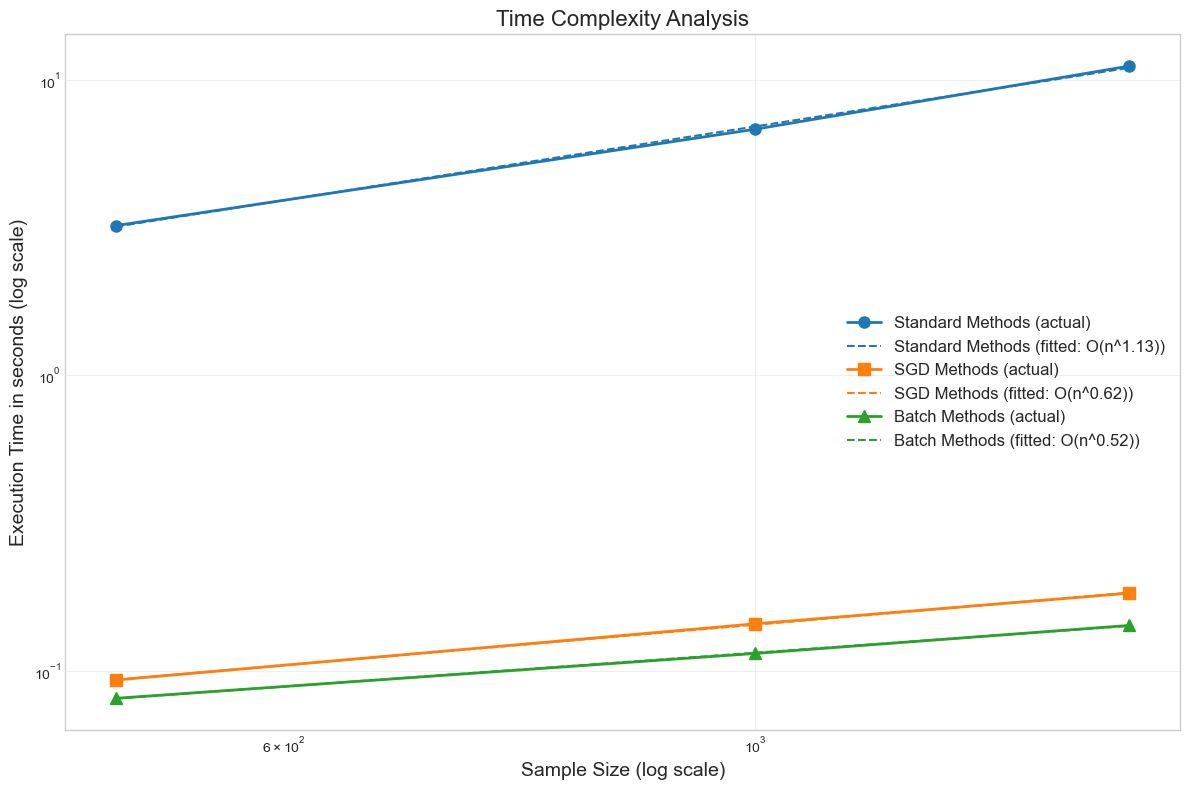

In [16]:
if __name__ == "__main__":
    main()